# Introduction of Delta Mush: Smoothing Deformations While Preserving Detail
#### 2021 - March - 30


Delta mush was developed by Rhythm & Hues and published 2014 on SIGGRAPH.<br> SIGGRAPH an annual conference on computer graphics organized by the ACM SIGGRAPH. This journal is the top journal in computer graphic area. You can find quite lot papers on SIGGRAPH are come from disney and pixar https://www.siggraph.org/ <br><br> Delta Mush is a Voodoo deformer. What it does is to smooth arbitrary deformation of a polygonal mesh without smoothing the original detail of the model.<br>  

### The most increditable usage of it is delta mush can replace weight painting on animating charactors

Let watch thier video of delta much https://www.fxguide.com/fxfeatured/voodoo-magic/

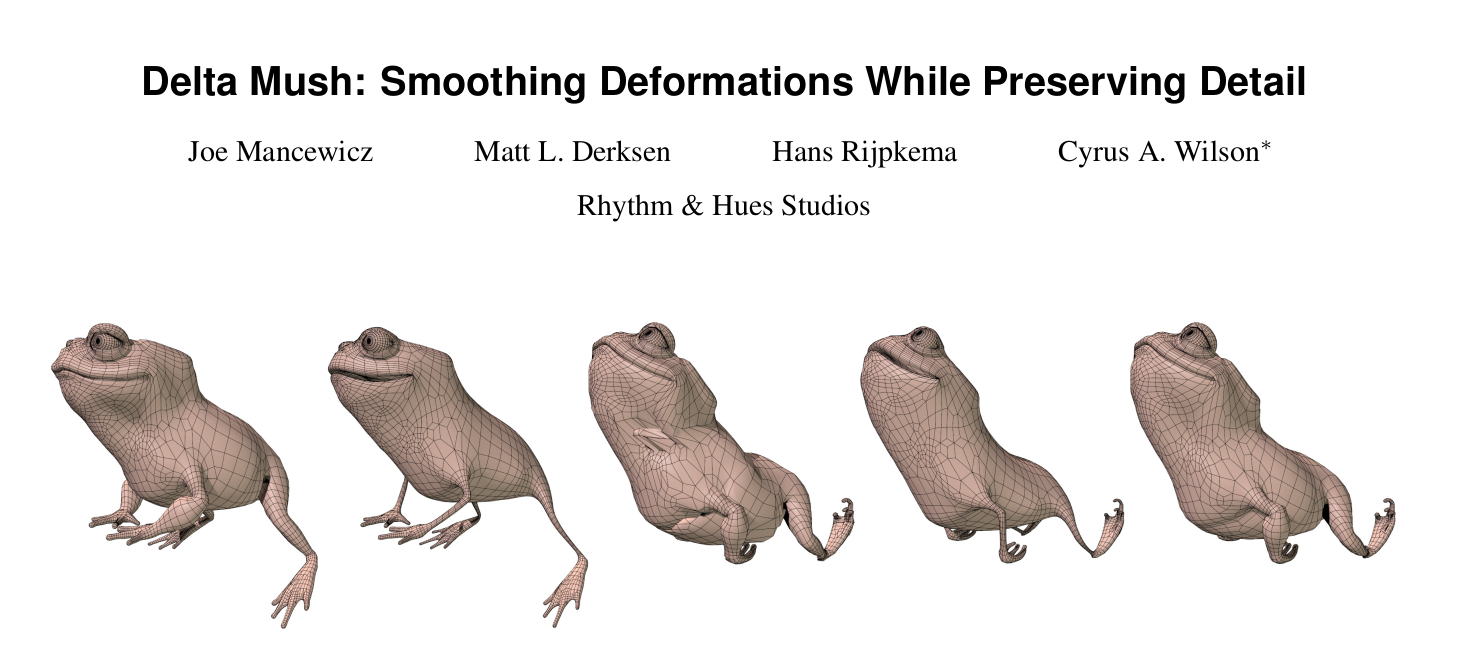

# Delta much core idea
The following images was extract from this presentation SIGGRAPH 2019 Presentation: Direct Delta Mush Skinning and Variants https://www.youtube.com/watch?v=o_eGdxnTWuI 

For this rigid mesh, we set joints inside the mesh and set 0 or 1 weight for each vertices of each joint. basically it means you attach each vertice to a certain joint. We can then build a kinematic tree of {0:1, 1:2} and deform them using linear skinning

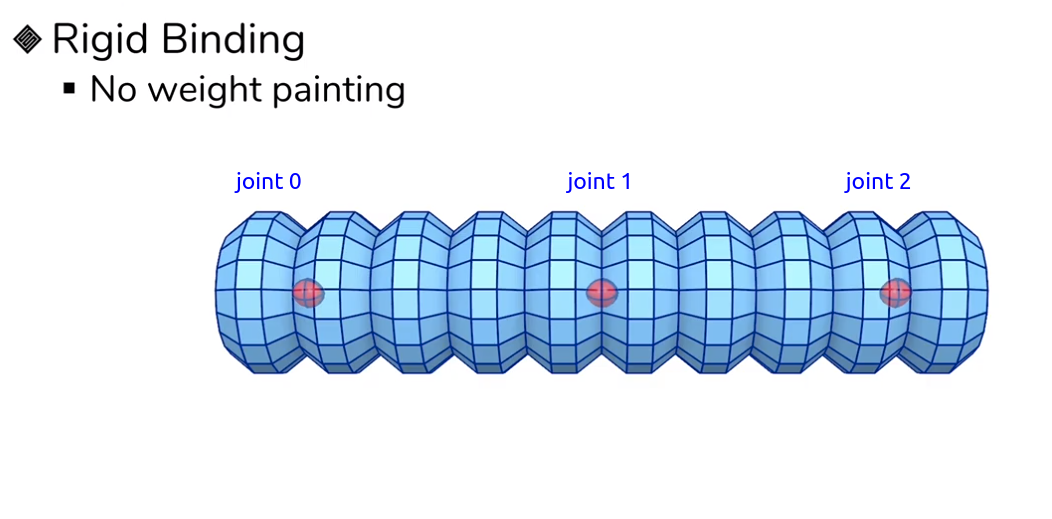

### We can see the geometry break when we animate the joint 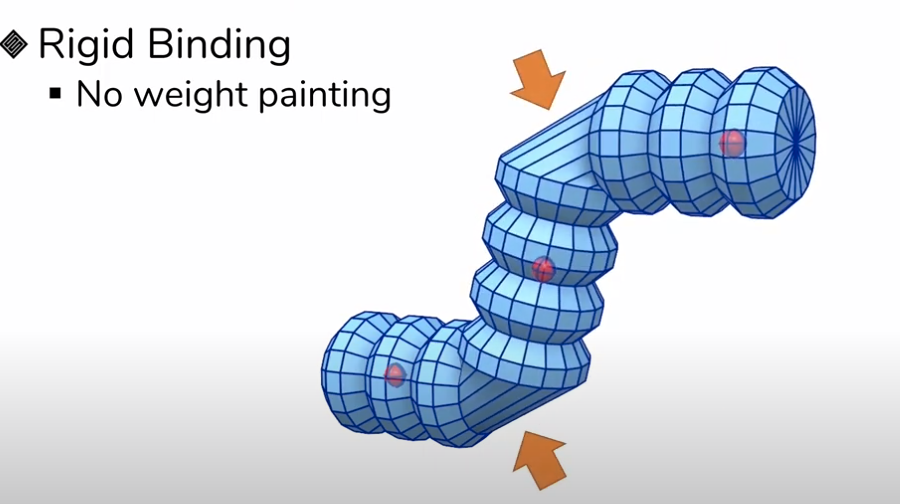

#### Represent it in tangent space of each vector rather than world space 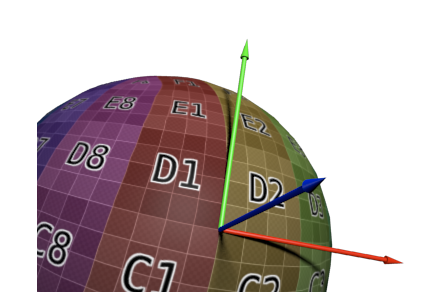

### How delta mush actually work
### 1. Smooth original mesh and compute 'Delta' in the rest pose shown as green vectors 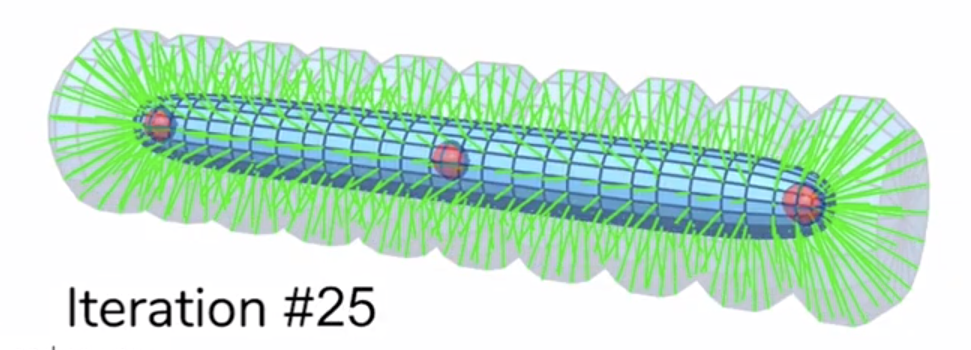  

### 2.  Smooth deformed mesh with laplacian smoothing 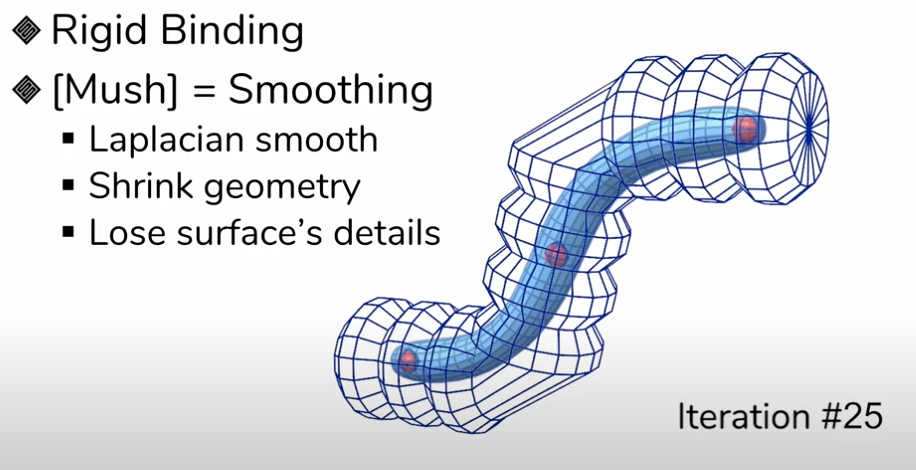

### 3. Add delta to smoothed animated mesh by adding the the vector in surface tangent space 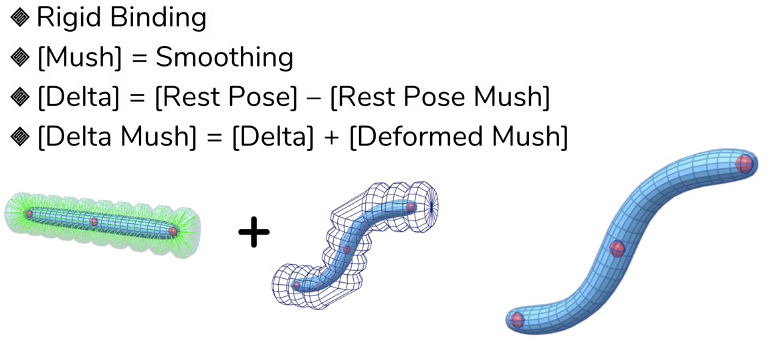

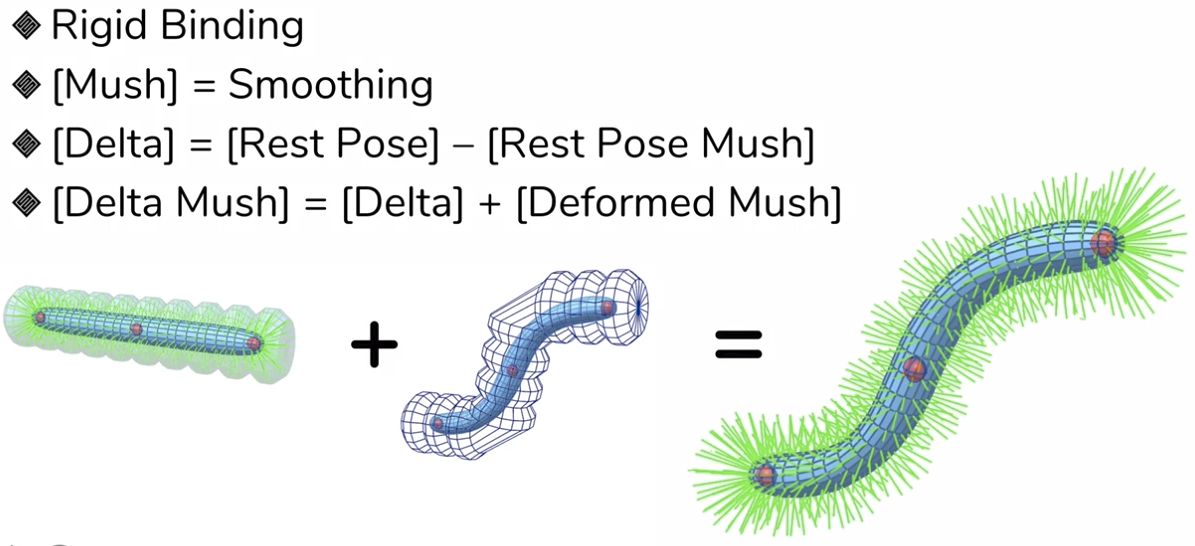

###  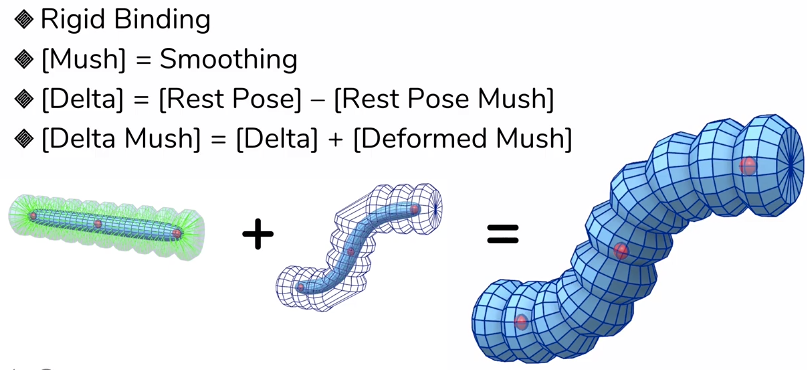

### Math part (more detail refer to attached paper) <br><br> 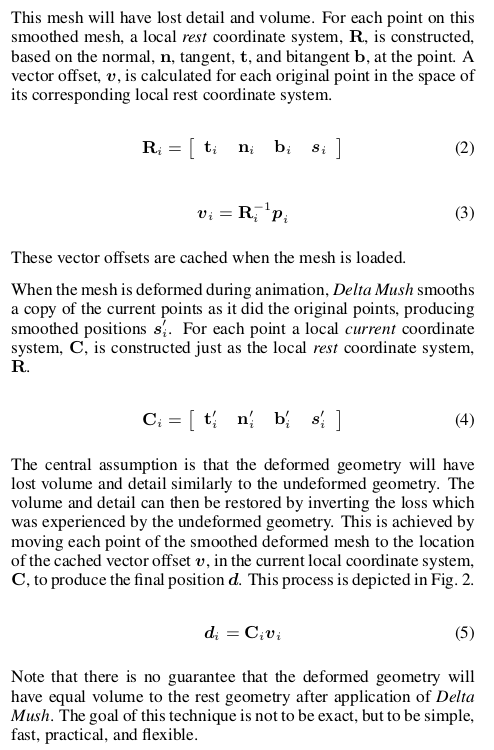

Look into one single vertex:  
  $$
    R_iv_i = P_i
    =
    \begin{bmatrix} t_{x} & n_{x} & b_{x} & s_{x} \\t_{y} & n_{y} & b_{y} & s_{y} \\t_{z} & n_{z} & b_{z} & s_{z}
    \end{bmatrix} 
    \begin{bmatrix} v_0 \\v_1 \\v_2 \\1
    \end{bmatrix} = 
    \begin{bmatrix} p_0 \\p_1 \\p_2
    \end{bmatrix}
 $$
 
 for $ [ t, n,b | s_i] $, $[t, n,b]$ is the base, $s_i$ is the offset
 <p>
  $$
    d_i
    =
    \begin{bmatrix} t'_{x} & n'_{x} & b'_{x} & s'_{x} \\t'_{y} & n'_{y} & b'_{y} & s'_{y} \\t'_{z} & n'_{z} & b'_{z} & s'_{z}
    \end{bmatrix} 
    \begin{bmatrix} v_0 \\v_1 \\v_2 \\1
    \end{bmatrix} = 
    \begin{bmatrix} d_0 \\d_1 \\d_2
    \end{bmatrix}
 $$

### Implement delta mush now!

### 1. create tube mesh

In [1]:
import numpy as np
import meshplot as mp
import trimesh
## base function
NORM = np.linalg.norm
def lap_smooth(v,f,adj):
    smoothed = v.copy()
    for i in range(v.shape[0]):
        neibour = adj[i]
        base_point = v[i]
        if 1:
            laplacian = np.vstack((v[neibour]))
            smoothed[i] = np.average(laplacian,0) 
            
        else:
            laplacian = np.zeros_like((base_point))
            edge_cost = 1/ NORM(v[neibour] - v[i],axis=1)
            laplacian += np.sum(v[neibour] * edge_cost.reshape(-1,1),axis=0)
            # laplacian += base_point
            total_weight = np.sum(edge_cost)
            if total_weight > 0:
                smoothed[i] = laplacian/total_weight
        # else:
        
    return smoothed

def smooth2(v,f,adj,iteration):
    for i in range(iteration):
        v = lap_smooth(v,f,adj)
    return v

def get_smoothed_mesh(v,f,iteration=5):
    adj = get_adj(v,f)
    smooth_verts = smooth2(v,f,adj,iteration)
    tri_mesh = trimesh.Trimesh(vertices=smooth_verts,faces=f,process=False)
    return tri_mesh

def get_adj(v,f):
    adj = []
    for i,vt in enumerate(v):
        neibour = set(f[np.where(f==i)[0]].flatten())
        # pdb.set_trace()
        # print(neibour)
        # print(i)
        neibour.remove(i)
        neibour = list(neibour)
        adj.append(neibour)
    return adj

def get_tagent_space_naive(mesh):
    normals = mesh.vertex_normals
    tangents = np.cross(normals,normals+[0,1,0])
    tangents = tangents/np.linalg.norm(tangents,axis=1).reshape(-1,1)
    bitangents = np.cross(normals,tangents)
    bitangents = bitangents/np.linalg.norm(bitangents,axis=1).reshape(-1,1)
    return tangents,normals,bitangents


def rotation_matrix_x(angle):
    rad = angle * np.pi / 180
    return np.array([[1,0,0],[0, np.cos(rad), -np.sin(rad)], [0, np.sin(rad), np.cos(rad)]])


def rotation_matrix_y(angle):
    rad = angle * np.pi / 180
    return np.array([[np.cos(rad), 0, np.sin(rad)],[0, 1, 0], [-np.sin(rad), 0, np.cos(rad)]])

def rotation_matrix_z(angle):
    rad = angle * np.pi / 180
    return np.array([[np.cos(rad), -np.sin(rad), 0], [np.sin(rad), np.cos(rad), 0], [0, 0, 1]])


def rotate_plane(vec1, vec2 ):
    """
    giving two vector, return the rotation matrix
    """
    
    #vec1 = vec1 / np.linalg.norm(vec1) #unit vector
    norm = np.linalg.norm(vec1) * np.linalg.norm(vec2)

    cos_theta = np.dot(vec1,vec2)/norm
    sin_theta = np.linalg.norm(np.cross(vec1,vec2))/norm
    if sin_theta == 0:
        return np.eye(3)
    k = np.cross(vec1,vec2) /(norm*sin_theta)
    K = np.array([[0,-k[2],k[1]],
                  [k[2],0,-k[0]],
                  [-k[1],k[0],0]])
    R = np.eye(3) + sin_theta*K +(1-cos_theta)*np.dot(K,K)

    return R

def get_index_list(full,part):
    idlist = []
    for pt in part:
        arr = NORM(full-pt,axis=1) < 0.001 
        id = np.where(arr)
        idlist.append(id[0][0])
    return idlist

def get_Rs(tangents,normals,bitangents):
    return np.dstack(( tangents,normals,bitangents))


def get_delta_mushed_target(source_v,target_v,f):
    smooth_time = 25
    smoothed_source_mesh = get_smoothed_mesh(source_v,f,smooth_time)
    st,sn,sb =  get_tagent_space_naive(smoothed_source_mesh)
    Rs = get_Rs(st,sn,sb)
    vd = np.einsum('ijk,ik->ij' ,np.linalg.pinv(Rs),source_v-smoothed_source_mesh.vertices)
    smoothed_target_mesh = get_smoothed_mesh(target_v,f,smooth_time)
    tn = smoothed_target_mesh.vertex_normals
    tt = np.zeros_like(tn)
    tb = np.zeros_like(tn)
    # key part: get rotated tangent space
    for i,vec1 in enumerate(tn):
        Rn = rotate_plane(sn[i],tn[i])
        tt[i],tb[i] = Rn @ st[i], Rn @ sb[i]
    Cs = get_Rs(tt,tn,tb)
    deformed = np.einsum('ijk,ik->ij' ,Cs,vd) + smoothed_target_mesh.vertices
    return deformed

In [3]:
source_mesh  = trimesh.load_mesh('./tube_r.off',process=False)
v,f = source_mesh.vertices,source_mesh.faces
# displace the tube
mp.plot(v, f)

/home/tingting/Desktop/netvirta/fullbody/fullbody.sg/env/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/tingting/Desktop/netvirta/fullbody/fullbody.sg/env/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [4]:
## deform tube
# t = [0.5,0,0.9]
rotation_angle_y = 45
center = np.average(v,0)
select = np.where(v[:,0]>center[0]+1)
R = rotation_matrix_z(rotation_angle_y)

target = v.copy()
target[:,0] -= 1  

target[select] = (R @ target[select].T).T
target[:,0] += 1
mp.plot(target, f,c=v[:, 0])

Invalid color array given! Supported are numpy arrays. <class 'trimesh.caching.TrackedArray'>


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.166265…

### smooth orginal mesh, present 'delta' in tagent space

In [5]:
# smooth original mesh
smooth_time = 25
smoothed_source_mesh = get_smoothed_mesh(v,f,smooth_time)
st,sn,sb =  get_tagent_space_naive(smoothed_source_mesh)
sv = smoothed_source_mesh.vertices
Rs = get_Rs(st,sn,sb)
vd = np.einsum('ijk,ik->ij' ,np.linalg.pinv(Rs),v-sv)


d = mp.plot(sv, f)
d.add_lines(sv, sv + sn * 0.2, shading={"line_color": "red"})
d.add_lines(sv, sv + st * 0.2, shading={"line_color": "green"})
d.add_lines(sv, sv + sb * 0.2, shading={"line_color": "blue"})
d = mp.plot(sv, f)
d.add_lines(v[f[:,0]], v[f[:,1]],shading={"line_color": "red"})
d.add_lines(v[f[:,1]], v[f[:,2]],shading={"line_color": "red"})
d.add_lines(v,sv,shading={"line_color": "green"});

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.013079…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.013079…

In [6]:
# smooth deformed target mesh

smoothed_target_mesh = get_smoothed_mesh(target,f,smooth_time)
tn = smoothed_target_mesh.vertex_normals
tt = np.zeros_like(tn)
tb = np.zeros_like(tn)
# key part: get rotated tangent space
for i,vec1 in enumerate(tn):
    Rn = rotate_plane(sn[i],tn[i])
    tt[i],tb[i] = Rn @ st[i], Rn @ sb[i]
tv = smoothed_target_mesh.vertices

d = mp.plot(tv, f)
d.add_lines(tv, tv + tn * 0.2, shading={"line_color": "red"})
d.add_lines(tv, tv + tt * 0.2, shading={"line_color": "green"})
d.add_lines(tv, tv + tb * 0.2, shading={"line_color": "blue"})

d = mp.plot(tv, f)
d.add_lines(target[f[:,0]], target[f[:,1]],shading={"line_color": "red"})
d.add_lines(target[f[:,1]], target[f[:,2]],shading={"line_color": "red"})
d.add_lines(target,tv,shading={"line_color": "green"});


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.427449…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.427449…

In [8]:
# create smoothed delta mush 
Cs = get_Rs(tt,tn,tb)
deformed = np.einsum('ijk,ik->ij' ,Cs,vd)+tv
mp.plot(deformed,f,c=v[:, 0])

Invalid color array given! Supported are numpy arrays. <class 'trimesh.caching.TrackedArray'>


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.189294…

### Research work of enhancing Delta mush
 * Direct Delta Mush Skinning and Variants, from google AI, aim to solve real time delta mush. <p> https://binh.graphics/papers/2019s-DDM/Direct_Delta_Mush_and_Variants.pdf
 * Enhanced Direct Delta Mush, from apple, ro solve delta mush on non-rigid. <p>  https://arxiv.org/pdf/2101.02798.pdf